In [131]:
import config
import json
import requests
import vulture_scraper as vulture
api_key = config.API_key
import time 
import datetime
import query_helper
import movieDB_functions 
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#results = movieDB_functions.search_and_get(api_key, ['blair witch project'])


In [2]:
query_helper.connect()

In [101]:
df = query_helper.query_to_df('''select * from tmdb_ inner join imdb on tmdb_.imdb_id=imdb.imdb_id''')


In [102]:
df.head()
df.columns

Index(['id', 'title', 'budget', 'revenue', 'genres', 'original_language',
       'overview', 'collection', 'popularity', 'production_companies',
       'production_country', 'release_date', 'run_time', 'spoken_lang',
       'tagline', 'vote_avg', 'vote_count', 'imdb_id', 'imdb_id', 'cast',
       'key_words', 'imdb_budget', 'imdb_revenue', 'rating_value',
       'rating_count'],
      dtype='object')

0                            [Comedy, Crime, ]
1       [Action, Thriller, Science, Fiction, ]
2                                [Animation, ]
3                         [Action, Thriller, ]
4                           [History, Drama, ]
                         ...                  
1656                                      None
1657                     [Action, Adventure, ]
1658              [Horror, Action, Thriller, ]
1659                       [Crime, Thriller, ]
1660                                 [Drama, ]
Name: genres, Length: 1661, dtype: object

In [104]:
df['genres'] = df['genres'].map(lambda x: x.split(' ') if type(x)==str else x)
#flat_list = [item for sublist in l for item in sublist]
unique_genres = [item for sublist in df['genres'] if type(sublist)==list for item in sublist]
unique_genres = list(set(unique_genres))
unique_genres.remove('')

In [158]:
df['production_companies'].value_counts()

Paramount                                                           23
Universal Pictures                                                  13
Columbia Pictures                                                   13
Warner Bros. Pictures                                               13
DreamWorks Animation                                                 8
                                                                    ..
Urania-Film Sfinks                                                   1
Brimstone Productions                                                1
Wilshire Court Productions G.C. Group Paramount Television           1
PorchLight Entertainment                                             1
RKO Radio Pictures Walt Disney Pictures Walt Disney Productions      1
Name: production_companies, Length: 991, dtype: int64

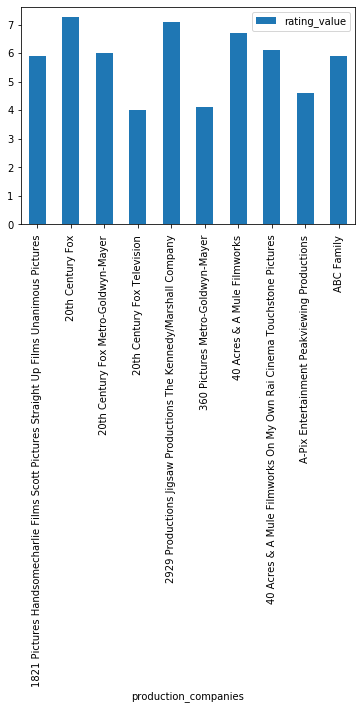

In [152]:
a = df[['rating_value','production_companies']].groupby('production_companies').mean()[:10].plot(kind='bar')


In [159]:
df['rating_value'].describe()

count    1530.000000
mean        6.402353
std         1.323874
min         1.200000
25%         5.700000
50%         6.600000
75%         7.300000
max         9.800000
Name: rating_value, dtype: float64

In [162]:
df_q1 = df[df['rating_value']>7.3]
df_q1

,id,title,budget,revenue,genres,original_language,overview,collection,popularity,production_companies,...,vote_avg,vote_count,imdb_id,imdb_id,cast,key_words,imdb_budget,imdb_revenue,rating_value,rating_count
0,100,"Lock, Stock and Two Smoking Barrels",1350000,28356188,"[Comedy, Crime, ]",en,A card shark and his unwillingly-enlisted frie...,None,7.332,Summit Entertainment The Steve Tisch Company S...,...,8.1,3404,tt0120735,tt0120735,None,"gangster, cockney accent, dark humor, low budg...",NaN,NaN,8.2,501681.0
4,10139,Milk,20000000,54586584,"[History, Drama, ]",en,"The true story of Harvey Milk, the first openl...",None,10.346,Groundswell Productions Jinks/Cohen Company,...,7.3,1224,tt1013753,tt1013753,None,"gay activist, gay, gay rights, california, gay...",NaN,NaN,7.5,157731.0
5,10141,Dirty Rotten Scoundrels,0,42039085,"[Crime, Comedy, ]",en,Two con men try to settle their rivalry by bet...,None,11.899,Orion Pictures,...,7.1,398,tt0095031,tt0095031,None,"bet, french riviera, rivalry, gigolo, pretendi...",NaN,NaN,7.4,60532.0
7,101628,The Making Of West Side Story,0,0,"[Documentary, Music, ]",en,"A documentary which shows, in great detail, th...",None,1.284,Deutsche Grammophon Unitel BBC,...,9.3,2,tt0308495,tt0308495,"1985 - Top of the Pops, Docs, Leonard Bernstei...","recording, making of, manhattan new york city,...",NaN,NaN,8.2,136.0
14,10217,The Sweet Hereafter,5000000,3263585,"[Drama, ]",en,A small mountain community in Canada is devast...,None,9.059,Alliance Communications Fine Line Features,...,7.1,193,tt0120255,tt0120255,Movies I need to see to complete the IMDb Top ...,"slut shaming, female pubic hair, female full f...",NaN,NaN,7.5,30395.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,95742,An African Election,0,0,"[History, Documentary, ]",en,Filmmaker Jarreth Merz directs this eye-openin...,None,1.656,None,...,8.0,3,tt1674131,tt1674131,"Documentaries : The Essential List, Best of 20...",,NaN,NaN,7.5,82.0
1649,9800,Philadelphia,26000000,206678440,"[Drama, ]",en,Two competing lawyers join forces to sue a pre...,None,10.891,Clinica Estetico TriStar Pictures,...,7.7,2206,tt0107818,tt0107818,None,"aids, city name in title, listening to opera, ...",NaN,NaN,7.7,210097.0
1650,9806,The Incredibles,92000000,631442092,"[Action, Adventure, Animation, Family, ]",en,Bob Parr has given up his superhero days to lo...,T h e I n c r e d i b l e s C o l l e c t ...,19.836,Pixar Walt Disney Pictures,...,7.7,11324,tt0317705,tt0317705,None,"superhero family, superhero, strong female cha...",92000000.0,261441092.0,8.0,617056.0
1651,981,The Philadelphia Story,0,0,"[Comedy, Romance, ]",en,When a rich woman's ex-husband and a tabloid-t...,None,9.142,Metro-Goldwyn-Mayer Loew's Incorporated,...,7.8,389,tt0032904,tt0032904,None,"love triangle, wedding, reporter, socialite, t...",NaN,NaN,7.9,59491.0


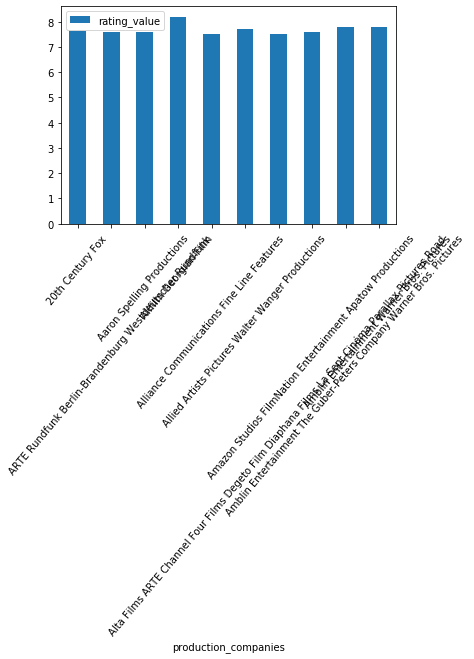

In [190]:
df_q1[['rating_value','production_companies']].groupby('production_companies').mean()[:10].plot(kind='bar',rot=50)
